In [2]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

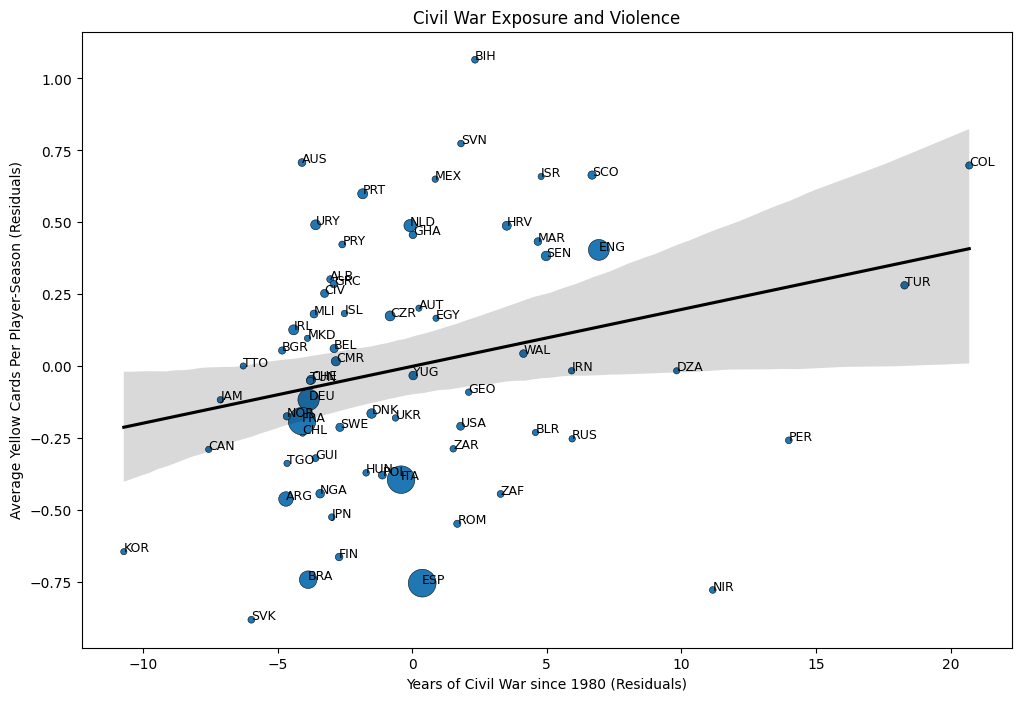

In [19]:
# Load data
wb_codes = pd.read_csv("http://dss.ucsd.edu/~ssaiegh/Soccer_Replication/Wb_codes.csv")
wb_codes = wb_codes.rename(columns={"id": "nation"})
wb_codes = wb_codes.sort_values(by="nation")
soccer_data = pd.read_stata("http://dss.ucsd.edu/~ssaiegh/Soccer_Replication/soccer_data.dta")

# drop num_country and missing contract
soccer_data = soccer_data.drop(columns=["num_country"])
soccer_data = soccer_data.dropna(subset=["contract"])

# only keep these leagues
top_leagues = ['italian', 'champions', 'english', 'french', 'german', 'spanish']
soccer_data['league'] = soccer_data[top_leagues].any(axis=1)

# get the number of players per country
league_counts = soccer_data[soccer_data['league']].groupby('nationality')['player_id'].count()
soccer_data['num_country'] = soccer_data['nationality'].map(league_counts)

# merge wb_codes
soccer_data = soccer_data.merge(wb_codes, how="left", on="nation")

# Collapse

collapsed = ['wb_code', 'yellow_card', 'civwar', 'nation', 'num_country', 'age',
             'games_start', 'games_sub', 'goalie', 'defender',
 'forward', 'midfield', 'goals', 'ln_contract', 
 'italian', 'champions', 'english', 'french', 'german', 'spanish',
    'africa', 'asia', 'lac', 'east_europe', 'oecd']

collapse_df = soccer_data[soccer_data['league'] & (soccer_data['num_country'] >= 5)]
collapse_df = collapse_df[collapsed].groupby('wb_code').mean().reset_index()


# regress for yellow_card
vars1 = ['age', 'games_start', 'games_sub', 'defender', 'forward', 'midfield',
           'goals', 'ln_contract', 'italian', 'champions', 'french', 'german', 'spanish',
           'africa', 'asia', 'lac', 'east_europe']
# making the regfression model
X1 = collapse_df[vars1]
X1 = sm.add_constant(X1)
y1 = collapse_df['yellow_card']
model1 = sm.OLS(y1, X1).fit()


collapse_df['yellow_hat'] = model1.fittedvalues
collapse_df['yellow_res'] = collapse_df['yellow_card'] - collapse_df['yellow_hat']


# regress for civwar
# making the regression model
y2 = collapse_df['civwar']
model2 = sm.OLS(y2, X1).fit()


collapse_df['war_hat'] = model2.fittedvalues
collapse_df['war_res'] = collapse_df['civwar'] - collapse_df['war_hat']


# scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='war_res', y='yellow_res', size='num_country', sizes=(20, 400),
    data=collapse_df, legend=False, marker='o', edgecolor='black'
)
sns.regplot(
    x='war_res', y='yellow_res', data=collapse_df, scatter=False, color='black'
)

# labelinfg points for each country
for i, row in collapse_df.iterrows():
    plt.text(row['war_res'], row['yellow_res'], str(row['wb_code']), fontsize=9)

plt.xlabel("Years of Civil War since 1980 (Residuals)")
plt.ylabel("Average Yellow Cards Per Player-Season (Residuals)")
plt.title("Civil War Exposure and Violence");

In [66]:
group_vars

NameError: name 'group_vars' is not defined

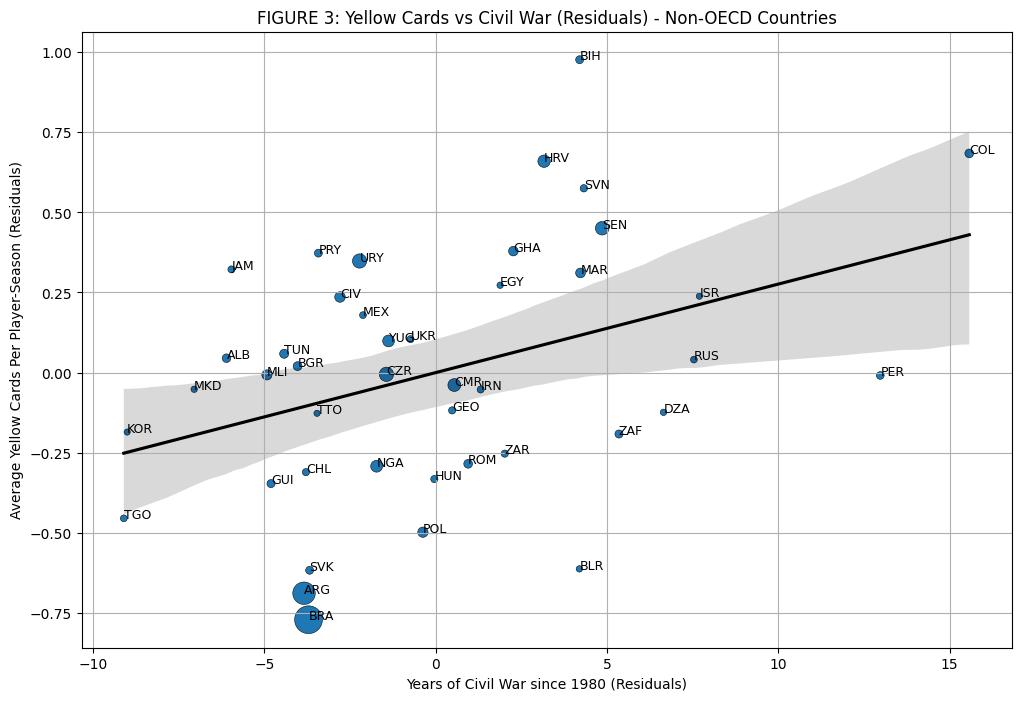

In [ ]:
# LOADING DATA
wb_codes = pd.read_csv("http://dss.ucsd.edu/~ssaiegh/Soccer_Replication/Wb_codes.csv")
wb_codes = wb_codes.rename(columns={"id": "nation"})
wb_codes = wb_codes.sort_values(by="nation")
soccer = pd.read_stata("http://dss.ucsd.edu/~ssaiegh/Soccer_Replication/soccer_data.dta")

# CLEANING AND FILTERING DATA
soccer = soccer.dropna(subset=["contract"])

# RELEVANT COUNTRIES: FROM "if (italian | champions |  english  | french | german | spanish)"
country_cols = ['italian', 'champions', 'english', 'french', 'german', 'spanish']
soccer['country_flag'] = soccer[country_cols].any(axis=1)

# PLAYER COUNT BY NATIONALITY
soccer['player_id'] = soccer['player_id'].astype(str)
soccer['num_country'] = soccer.groupby('nationality')['player_id'].transform(
    lambda x: x.count() if soccer.loc[x.index, 'country_flag'].any() else np.nan
)

soccer = soccer[soccer['oecd'] == 0]

soccer = soccer.merge(wb_codes, how="left", on="nation")

# GROUP SELECTED COLUMNS BY wb_code AND AGGREGATE BY MEAN
group_vars = [
    'wb_code', 'nation', 'civwar', 'age', 'games_start', 'games_sub',
    'goalie', 'defender', 'forward', 'midfield', 'goals', 'ln_contract'
] + country_cols + ['africa', 'asia', 'lac', 'east_europe', 'oecd', 'yellow_card', 'num_country']

collapse_df = soccer[soccer['country_flag'] & (soccer['num_country'] >= 5)]
collapse_df = collapse_df[group_vars].groupby('wb_code').mean().reset_index()

# FIRST REGRESSION: BY YELLOW CARD
X1_vars = ['age', 'games_start', 'games_sub', 'defender', 'forward', 'midfield',
           'goals', 'ln_contract', 'italian', 'champions', 'french', 'german', 'spanish',
           'africa', 'asia', 'lac', 'east_europe']
X1 = collapse_df[X1_vars]
X1 = sm.add_constant(X1)
y1 = collapse_df['yellow_card']
model1 = sm.OLS(y1, X1).fit()
collapse_df['yellowhat'] = model1.fittedvalues
collapse_df['yellow_res'] = collapse_df['yellow_card'] - collapse_df['yellowhat']

# SECOND REGRESSION: BY CIVIL WAR 
y2 = collapse_df['civwar']
model2 = sm.OLS(y2, X1).fit()
collapse_df['warhat'] = model2.fittedvalues
collapse_df['war_res'] = collapse_df['civwar'] - collapse_df['warhat']

# PLOTTING
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='war_res', y='yellow_res', size='num_country', sizes=(20, 400),
    data=collapse_df, legend=False, marker='o', edgecolor='black'
)
sns.regplot(
    x='war_res', y='yellow_res', data=collapse_df, scatter=False, color='black'
)

for i, row in collapse_df.iterrows():
    plt.text(row['war_res'], row['yellow_res'], str(row['wb_code']), fontsize=9)

plt.xlabel("Years of Civil War since 1980 (Residuals)")
plt.ylabel("Average Yellow Cards Per Player-Season (Residuals)")
plt.title("FIGURE 3: Yellow Cards vs Civil War (Residuals) - Non-OECD Countries")
plt.grid(True)
plt.show()

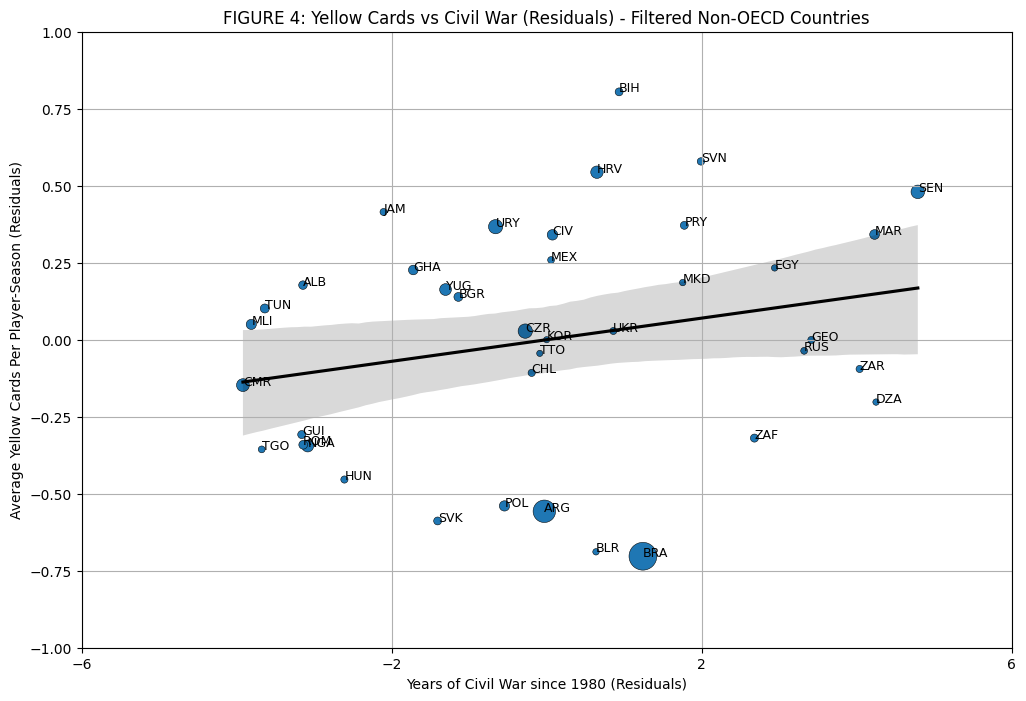

In [ ]:



wb_codes = pd.read_csv("http://dss.ucsd.edu/~ssaiegh/Soccer_Replication/Wb_codes.csv")
wb_codes = wb_codes.rename(columns={"id": "nation"})
wb_codes = wb_codes.sort_values(by="nation")

#Load soccer and clean
soccer = pd.read_stata("http://dss.ucsd.edu/~ssaiegh/Soccer_Replication/soccer_data.dta")
soccer = soccer.dropna(subset=["contract"])
soccer['country_flag'] = soccer[['italian', 'champions', 'english', 'french', 'german', 'spanish']].any(axis=1)
soccer['player_id'] = soccer['player_id'].astype(str)
soccer['num_country'] = soccer.groupby('nationality')['player_id'].transform(
    lambda x: x.count() if soccer.loc[x.index, 'country_flag'].any() else np.nan
)
soccer = soccer[soccer['oecd'] == 0]
nations_drop = [23, 52, 54, 78, 101]
soccer = soccer[~soccer['nation'].isin(nations_drop)]

soccer = soccer.merge(wb_codes, how="left", on="nation")

group_vars = [
    'wb_code', 'nation', 'civwar', 'age', 'games_start', 'games_sub',
    'goalie', 'defender', 'forward', 'midfield', 'goals', 'ln_contract'
] + country_cols + ['africa', 'asia', 'lac', 'east_europe', 'oecd', 'yellow_card', 'num_country']

collapse_df = soccer[soccer['country_flag'] & (soccer['num_country'] >= 5)]
collapse_df = collapse_df[group_vars].groupby('wb_code').mean().reset_index()


#Regress
X1_vars = ['age', 'games_start', 'games_sub', 'defender', 'forward', 'midfield',
           'goals', 'ln_contract', 'italian', 'champions', 'french', 'german', 'spanish',
           'africa', 'asia', 'lac', 'east_europe']
X1 = collapse_df[X1_vars]
X1 = sm.add_constant(X1)
y1 = collapse_df['yellow_card']
model1 = sm.OLS(y1, X1).fit()
collapse_df['yellowhat'] = model1.fittedvalues
collapse_df['yellow_res'] = collapse_df['yellow_card'] - collapse_df['yellowhat']

y2 = collapse_df['civwar']
model2 = sm.OLS(y2, X1).fit()
collapse_df['warhat'] = model2.fittedvalues
collapse_df['war_res'] = collapse_df['civwar'] - collapse_df['warhat']

#PLOTTTTT
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='war_res', y='yellow_res', size='num_country', sizes=(20, 400),
    data=collapse_df, legend=False, marker='o', edgecolor='black'
)
sns.regplot(
    x='war_res', y='yellow_res', data=collapse_df, scatter=False, color='black'
)

for _, row in collapse_df.iterrows():
    plt.text(row['war_res'], row['yellow_res'], str(row['wb_code']), fontsize=9)

plt.xlabel("Years of Civil War since 1980 (Residuals)")
plt.ylabel("Average Yellow Cards Per Player-Season (Residuals)")
plt.title("FIGURE 4: Yellow Cards vs Civil War (Residuals) - Filtered Non-OECD Countries")
plt.xticks(np.arange(-6, 7, 4))
plt.yticks(np.arange(-1, 1.25, 0.25))
plt.grid(True)
plt.show()
